# 1. What is the difference between multithreading and multiprocessing?

- Multithreading and multiprocessing are methods used to achieve concurrency in a program, but they differ significantly in how they utilize system resources, particularly memory and CPU cores.

    Multithreading : Multithreading involves a single process that divides its work into multiple, independently executing parts called threads.
- Shared Memory: All threads within the same process share the same memory space. This makes communication and data sharing between threads very fast and easy, as they can directly access the same variables.
- Overhead: Creating and switching between threads is generally lightweight and fast, as the operating system doesn't need to set up a new address space.
- Concurrency vs. Parallelism: On a single-core CPU, threads achieve concurrency (interleaving execution). On a multi-core CPU, they can achieve true parallelism (simultaneous execution).
- Risk: Due to shared memory, managing access to shared data (to prevent race conditions) requires careful synchronization mechanisms like locks and semaphores.
- Example: A word processor where one thread handles user input and another thread performs background spell-checking.

     Multiprocessing : Multiprocessing involves running multiple, independent processes, each with its own state and resources.
- Separate Memory: Each process has its own separate and independent memory space (address space). This isolation is a key difference.
- Overhead: Creating and switching between processes is generally heavyweight and slower, as the OS must allocate a completely new set of resources.
- Parallelism: Multiprocessing is excellent for achieving true parallelism as the processes can run independently on different CPU cores.
- Inter-Process Communication (IPC): Communication between processes is more complex and slower, typically requiring explicit IPC mechanisms like pipes, queues, or sockets.
- Safety: The separate memory spaces provide inherent memory protection, meaning a crash in one process typically does not affect others. This makes multiprocessing ideal for CPU-bound or critical tasks.
- Example: Running multiple, separate instances of a web browser or a compilation job spread across several cores.


# 2. What are the challenges associated with memory management in Python?

- Memory management in Python (especially in the standard CPython implementation) largely “happens for you” (through reference counting + garbage collection) — but that doesn’t mean it’s free of challenges. Here are some of the main issues, along with what you should keep an eye on.

    How Python handles memory (overview):

    Before listing the problems, it helps to recall how Python manages memory:
- Every object has a reference count; when it drops to zero the object can be deallocated.
- To catch cycles (objects referencing each other) that reference counting alone cannot free, Python also uses a generational garbage collector.
- For small objects, Python uses a memory-pooling allocator (pymalloc) and other optimisations (to reduce fragmentation, improve speed) instead of asking the OS for every allocation.

   Because of this, many simple use-cases work smoothly. But there are caveats.

   Major challenges in Python’s memory management:

   Here are some of the key difficulties:
1. Circular references and garbage collection overhead:
- Reference counting cannot by itself reclaim objects that reference each other in a cycle (e.g., A → B → A).
- While the garbage collector handles many cycles, it introduces overhead, unpredictable pauses, and more complexity.
- Example: Objects with __del__() methods (finalisers) complicate cycle detection and collection.
2. Memory leaks / lingering references:
- Even with automatic memory management, “leaks” can still happen: objects that are no longer useful but are still referenced (directly or indirectly) so they cannot be freed.
- For example: global data structures (lists/dicts) accumulating unused items, or caching mechanisms that never clear. (Also external libraries or extensions holding onto memory.)
3. Memory fragmentation and inefficient reuse:
- Over time, lots of allocations/deallocations of varying sizes can lead to fragmentation in the heap: unused memory “holes” that can’t be used for new large objects efficiently.
- Also, because Python’s memory manager doesn’t always return freed memory back to the OS immediately, the process memory footprint may stay high even though logically many objects are gone.
4. Performance overhead of automatic memory management:
- Garbage collection, cycle detection and general bookkeeping cost CPU and may introduce pauses (especially when many objects exist).
- Because of pooling, internal memory management, etc., memory behaviour is less transparent to the programmer, which can make performance tuning harder.
5. Limited direct control over memory vs low-level languages
- Because Python abstracts away allocation/deallocation, there is less fine-grained control compared to languages like C/C++. That means if you need very tight memory control (for embedded systems, high-performance real-time systems), Python’s abstractions may become a limitation.
- Also, when you interop with native extensions (C/C++ modules) or use external libraries, control becomes more complex and you may inadvertently cause memory misuse.
6. Large object retention and unexpected memory growth:
- If you keep references to large containers (e.g., big lists, dictionaries, dataframes) even unintentionally, memory usage can grow and not be reclaimed until you explicitly drop references.
- String concatenation or repeated creation of many short-lived objects can also stress memory. For example, using += on strings repeatedly can cause new allocations.
7. Interaction with OS memory and process footprint:
- Python’s memory manager may free objects internally but not necessarily shrink the process’s virtual memory size seen by the OS. The OS may not regain those pages for other processes.
- In long-running processes (web servers, microservices) this can lead to “apparent” memory leaks or ever-growing memory footprints even though logic is correct.

    Some best practices / pointers:
    
    To mitigate or avoid many of the above issues:
- Use tools for profiling memory usage: modules like gc, tracemalloc, or third-party profilers to see what objects are live.
- Avoid unnecessary large persistent data structures; drop references when not needed (e.g., clear lists, delete variables) so objects become unreachable.
- For large or streaming data, use generators, iterators, or streaming APIs rather than loading everything into memory at once.
- Be aware of libraries and extensions: if they allocate memory externally (C extensions), you may need to check for leaks there.
- Avoid creating many objects in tight loops if possible; reuse objects or use more efficient data structures.
- Monitor process memory footprint over time (especially for long-running applications); check for trends of growth.
- When necessary, you can manually trigger garbage collection (gc.collect()), although this is normally only required in special cases.
- If you’re doing performance-sensitive work or embedding into systems with constrained memory, consider memory-efficient patterns (e.g., using __slots__, more compact containers, avoiding large object retention).




In [1]:
#  3. Write a Python program that logs an error message to a log file when a division by zero exception occurs

import logging

def setup_logger(log_file: str):
    """
    Set up a logger that writes ERROR (and above) messages to the given log file.
    """
    logging.basicConfig(
        filename=log_file,
        level=logging.ERROR,
        format='%(asctime)s %(levelname)s %(name)s %(message)s'
    )

def divide(a, b):
    """
    Divides a by b, catching division-by-zero errors and logging them.
    Returns the result if successful, or None if an error occurred.
    """
    try:
        result = a / b
    except ZeroDivisionError as e:
        # Log the exception with full traceback information
        logging.exception("Division by zero error when dividing %s by %s", a, b)
        return None
    else:
        return result

if __name__ == "__main__":
    setup_logger("errors.log")

    x = 10
    y = 0
    res = divide(x, y)
    if res is None:
        print("Could not compute division due to an error. Check the log file.")
    else:
        print("Result:", res)


ERROR:root:Division by zero error when dividing 10 by 0
Traceback (most recent call last):
  File "/tmp/ipython-input-2449831040.py", line 21, in divide
    result = a / b
             ~~^~~
ZeroDivisionError: division by zero


Could not compute division due to an error. Check the log file.


In [5]:
# 4.Write a Python program that reads from one file and writes its content to another file.

import shutil
import os
import sys

def create_dummy_source(filepath: str) -> None:
    """Creates a simple file with content for testing the copy function."""
    content = (
        "This is the content of the source file.\n"
        "It contains multiple lines to ensure the copy is complete.\n"
        "Python's standard library provides powerful tools for file handling!"
    )
    try:
        with open(filepath, 'w', encoding='utf-8') as f:
            f.write(content)
        print(f"--- Created dummy source file: '{filepath}' ---")
    except IOError as e:
        print(f"Error creating source file: {e}", file=sys.stderr)
        sys.exit(1)


def copy_file_content(source_path: str, dest_path: str) -> None:
    """
    Copies the content from source_path to dest_path using shutil.copyfile,
    which is the most efficient method for this task in Python.
    """
    print(f"\nAttempting to copy from '{source_path}' to '{dest_path}'...")
    try:
        shutil.copyfile(source_path, dest_path)
        print("✅ Success! File content copied successfully.")

        with open(dest_path, 'r', encoding='utf-8') as f:
            verification_content = f.read()
        print(f"--- Destination file content ({len(verification_content.splitlines())} lines) ---")
        print(verification_content)
        print("------------------------------------------------------------------")

    except FileNotFoundError:
        print(f"❌ Error: Source file '{source_path}' not found.")
    except PermissionError:
        print(f"❌ Error: Permission denied. Cannot read or write files.")
    except Exception as e:
        print(f"❌ An unexpected error occurred during copy: {e}")


if __name__ == "__main__":
    SOURCE_FILE = "source_document.txt"
    DESTINATION_FILE = "copied_document.txt"

    create_dummy_source(SOURCE_FILE)

    copy_file_content(SOURCE_FILE, DESTINATION_FILE)


--- Created dummy source file: 'source_document.txt' ---

Attempting to copy from 'source_document.txt' to 'copied_document.txt'...
✅ Success! File content copied successfully.
--- Destination file content (3 lines) ---
This is the content of the source file.
It contains multiple lines to ensure the copy is complete.
Python's standard library provides powerful tools for file handling!
------------------------------------------------------------------


In [8]:
# 5.Write a program that handles both IndexError and KeyError using a try-except block.

import logging

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

def process_data_access(data_structure, lookup_key, access_index):
    """
    Attempts to access a dictionary using a key and a list using an index
    within a single try block, catching KeyError and IndexError separately.
    """
    logging.info(f"--- Attempting lookup with key '{lookup_key}' and index {access_index} ---")

    try:
        if isinstance(data_structure, dict):
            value = data_structure[lookup_key]
            logging.info(f"Dictionary access successful: Key '{lookup_key}' -> {value}")

        elif isinstance(data_structure, list):
            item = data_structure[access_index]
            logging.info(f"List access successful: Index {access_index} -> {item}")

        print("Operation completed without specific data access errors.")

    except KeyError as e:
        print(f"❌ Error Caught: KeyError! The key '{e}' does not exist in the dictionary.")
        logging.error(f"Failed dictionary lookup for key: {e}")

    except IndexError as e:
        print(f"❌ Error Caught: IndexError! The index is out of bounds for the list.")
        logging.error(f"Failed list lookup due to invalid index: {e}")

    except Exception as e:
        print(f"❌ An unexpected error occurred: {e}")
        logging.critical(f"Unhandled error: {e}")
    finally:
        print("Access attempt concluded.")


if __name__ == "__main__":
    my_dict = {"name": "Alice", "age": 30}
    my_list = ["apple", "banana", "cherry"]

    print("\n" + "="*50)
    print("Scenario 1: Testing for a KeyError (Non-existent dictionary key)")
    print("="*50)
    process_data_access(my_dict, lookup_key="city", access_index=0)

    print("\n" + "="*50)
    print("Scenario 2: Testing for an IndexError (Out-of-bounds list index)")
    print("="*50)
    process_data_access(my_list, lookup_key=None, access_index=5)

    print("\n" + "="*50)
    print("Scenario 3: Testing for a Successful Access")
    print("="*50)
    process_data_access(my_list, lookup_key=None, access_index=1)

ERROR:root:Failed dictionary lookup for key: 'city'
ERROR:root:Failed list lookup due to invalid index: list index out of range



Scenario 1: Testing for a KeyError (Non-existent dictionary key)
❌ Error Caught: KeyError! The key ''city'' does not exist in the dictionary.
Access attempt concluded.

Scenario 2: Testing for an IndexError (Out-of-bounds list index)
❌ Error Caught: IndexError! The index is out of bounds for the list.
Access attempt concluded.

Scenario 3: Testing for a Successful Access
Operation completed without specific data access errors.
Access attempt concluded.


# 6. What are the differences between NumPy arrays and Python lists?

      Differences:
1. Homogeneity of elements:
- Python lists can contain elements of different data types (e.g., integers, strings, floats) in the same list.
- NumPy arrays require (virtually always) that all elements are of the same data type (homogeneous) which allows for contiguous memory and fast numerical operations.
2. Memory layout / efficiency:
- Lists are arrays of pointers to Python objects; each element is a full Python object. This means extra overhead (type info, reference count, etc.).
- NumPy arrays use a contiguous block of memory (for the data buffer) plus metadata for shape/strides, etc. This contiguous layout improves cache locality and memory efficiency for large numeric datasets.
3. Performance for numeric operations:
- If you want to do element-wise arithmetic on large collections of numbers, lists tend to be much slower (you’d typically loop in Python).
- NumPy arrays support vectorized operations (e.g., array1 + array2, array * scalar, etc.) implemented in C under the hood, giving large performance gains.
4. Flexibility vs specialization:
- Lists are more flexible: you can append elements easily, mix types, shrink/grow, use them for varied kinds of data.
- NumPy arrays sacrifice some of that flexibility (due to homogeneous types and contiguous memory) but gain performance and numerical-computation suitability.
5. Operations and functionality:
- With lists, you don’t have built-in vectorized arithmetic or many specialized numerical routines; to add 1 to every element you’d typically loop.
- NumPy arrays come with many built-in methods for slicing multi-dimensional arrays, broadcasting, linear algebra, etc. They are designed for scientific computing and large-scale data.
6. Use case considerations:
- If your data is small, or heterogenous, or you just need a simple flexible container – lists may suffice.
- If you are working with large numeric datasets (millions of numbers), need efficient memory use, fast arithmetic, matrix operations – then NumPy arrays are generally the better choice.

     Why this matters (practical implications):
- Memory consumption: With large number of elements, lists can use significantly more memory than a comparable NumPy array. For instance one article shows that for 1 000 elements a list has per-element overhead vs an array’s leaner storage.
- Speed: In a benchmark in one source, doing an element-wise operation on a list (with a loop) was much slower than the direct array operation.
- Ease of numeric programming: When you want to compute say array + 4 (add 4 to every element), with a list you’d write a loop; with NumPy you can just do arr + 4 and all elements are updated efficiently.
- Flexibility: If you need flexible data structures (e.g., mixed types, nested variable-length lists, dynamic growth & shrink), lists shine.


    When to choose which:
- Use a list when:
- Your data is heterogenous (mixed types) or unlikely to be processed numerically in bulk.
- You need frequent appends/removals, or dynamic resizing.
- Performance is not a critical concern.
- Use a NumPy array when:
- You have large sets of numeric (same type) data.
- You plan to do bulk mathematical operations, slicing, linear algebra, etc.
- Memory footprint and computation speed matter.


# 7. Explain the difference between apply() and map() in Pandas.


      What each does:
        
      Series.map():
- Defined on a Series only (i.e., a single column).
- Accepts a function or a dictionary/Series to map values. For example:
- Performs element-wise transformation: each value in the Series is transformed independently.
- Good for simple value-to-value replacement or transformation of a single column.
    
     apply():
- Defined for both Series and DataFrame.
- When used on a Series, works like an element-wise transformation (but with more flexibility). When used on a DataFrame, you can apply a function along an axis (rows or columns) via the axis parameter.      
- More powerful / general: you can apply a function that takes a whole row (or whole column) and returns something based on multiple values in that row/column.    

    When to use which:
- Use map() when:
- You have one column (Series) and you want to transform each value independently (no dependence on other columns).
- You might even have a dictionary of replacements or mappings.
- You don’t need to look at other columns/rows in your logic.
- Use apply() when:
- You need to consider multiple columns in a row (or multiple rows) when computing your result.
- You’re applying a function that takes a Series (row or column) as input, not just a single value.
- You’re working at the DataFrame level and need to control axis, or do aggregations.
- You want more flexibility (e.g., keyword arguments, args, etc).

       

     

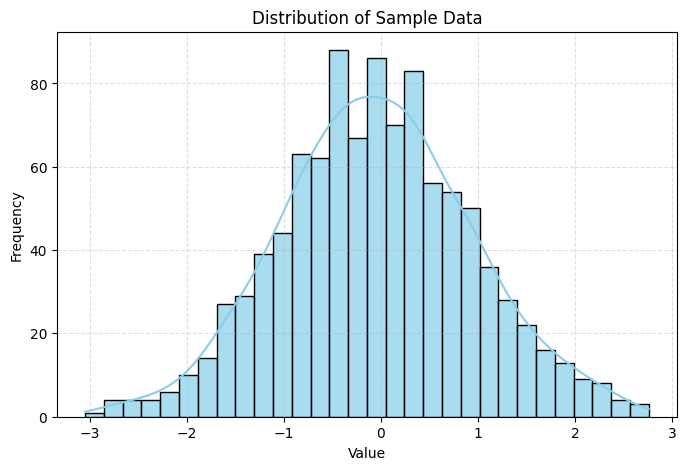

In [10]:
# 8. Create a histogram using Seaborn to visualize a distribution.


import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


np.random.seed(0)
data = np.random.randn(1000)

plt.figure(figsize=(8, 5))
sns.histplot(data=data,
             bins=30,
             kde=True,
             color='skyblue',
             edgecolor='black',
             alpha=0.7)

plt.title("Distribution of Sample Data")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.4)


plt.show()


In [25]:
# 9.Use Pandas to load a CSV file and display its first 5 rows.


import pandas as pd

df = pd.read_csv("services.csv")

print(df.head())


   id  location_id  program_id accepted_payments alternate_name  \
0   1            1         NaN               NaN            NaN   
1   2            2         NaN               NaN            NaN   
2   3            3         NaN               NaN            NaN   
3   4            4         NaN               NaN            NaN   
4   5            5         NaN               NaN            NaN   

                           application_process  \
0                   Walk in or apply by phone.   
1           Apply by phone for an appointment.   
2  Phone for information (403-4300 Ext. 4322).   
3                              Apply by phone.   
4                       Phone for information.   

                                            audience  \
0  Older adults age 55 or over, ethnic minorities...   
1       Residents of San Mateo County age 55 or over   
2  Older adults age 55 or over who can benefit fr...   
3  Parents, children, families with problems of c...   
4  Low-income wo

--- Loading Iris Dataset and Calculating Correlation Matrix ---

Calculated Correlation Matrix:
              sepal_length  sepal_width  petal_length  petal_width
sepal_length      1.000000    -0.117570      0.871754     0.817941
sepal_width      -0.117570     1.000000     -0.428440    -0.366126
petal_length      0.871754    -0.428440      1.000000     0.962865
petal_width       0.817941    -0.366126      0.962865     1.000000


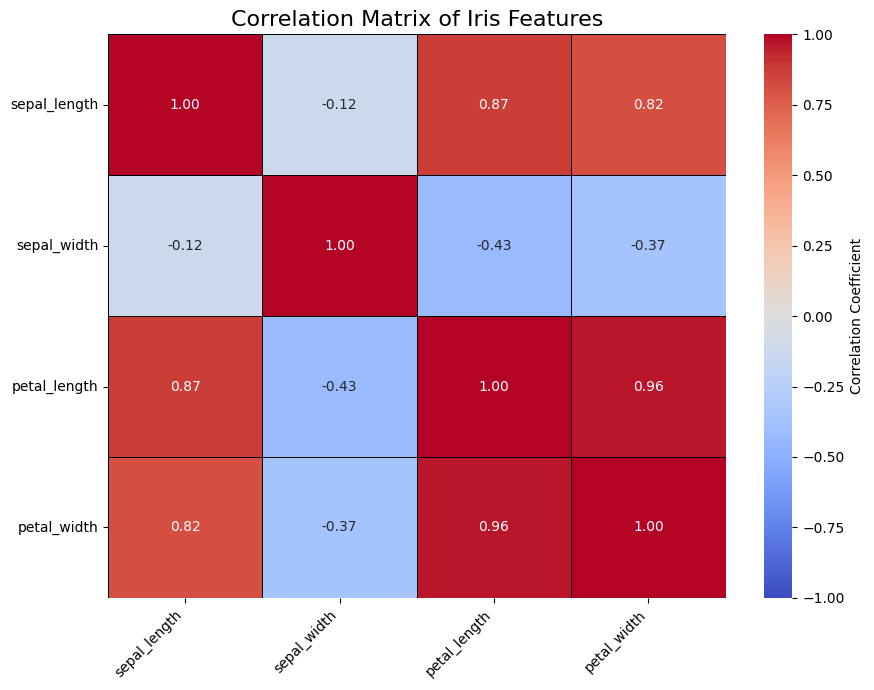


--- Heatmap visualization complete. ---


In [24]:
#  10.Calculate the correlation matrix using Seaborn and visualize it with a heatmap.


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def calculate_and_plot_correlation():
    """
    Loads the Iris dataset, calculates the correlation matrix of its
    numerical features, and displays the result as a heatmap.
    """
    print("--- Loading Iris Dataset and Calculating Correlation Matrix ---")


    try:
        df = sns.load_dataset("iris")
    except ValueError:
        print("Error: Could not load the built-in 'iris' dataset.")
        return

    df_numeric = df.select_dtypes(include=["number"])

    corr_matrix = df_numeric.corr()

    print("\nCalculated Correlation Matrix:")
    print(corr_matrix)

    plt.figure(figsize=(9, 7))
    sns.heatmap(
        corr_matrix,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        vmin=-1, vmax=1,
        linewidths=0.5,
        linecolor='black',
        cbar_kws={'label': 'Correlation Coefficient'}
    )
    plt.title("Correlation Matrix of Iris Features", fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    print("\n--- Heatmap visualization complete. ---")


if __name__ == "__main__":
    calculate_and_plot_correlation()